In [14]:
# Set Up
import os
import torch
from torch import nn

from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [55]:
# Data Loader
class DataLoader():
  def __init__(self, dir="MyDrive/data", width=300, height=432):
    self.width = width
    self.height = height
    self.root = dir

  def load(self, dataset="/test", batchSize=10, shuffle=True, workers=2):
    transform = transforms.Compose([transforms.Resize((124, 124)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=self.root + dataset, transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=shuffle, num_workers=workers)
    return dataset


In [62]:
# Multilayer Perceptron
class MLP(nn.Module):
  def __init__(self, inputSize=124*124*3, outputSize=8, lr=0.0001):
    super().__init__()

    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputSize, 1024),
      nn.ReLU(),
      nn.Dropout(0.03),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(0.03),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.03),
      nn.Linear(256, outputSize),
    )

    self.lr = lr

    # self.writer = SummaryWriter(log_dir="MyDrive/ICT303_Results/MLP")

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    # print(y, y_hat)
    fn = nn.CrossEntropyLoss()
    return fn(y_hat, y)

  def configureOptimiser(self):
    return torch.optim.Adam(self.parameters(), self.lr)

  def save(self, dir="MyDrive/ICT303_Results/MLP", trainedEpochs=0):
    savePath = (dir + f"/MLP_Epoch_{int(trainedEpochs)}.tar")
    torch.save(
        dict(model=self.net.state_dict(),
             learningRate=self.lr,
             epochsTrained=trainedEpochs),
        savePath)
    print(f"MLP saved to {savePath} at Epoch {trainedEpochs}")

  def load(self, dir="MyDrive/ICT303_Results/MLP"):
    checkpoint = torch.load(dir, weights_only=True)
    self.model.load_state_dict(checkpoint['model'])
    self.lr = checkpoint['learningRate']
    epochs = checkpoint['epochsTrained']
    return epochs

In [63]:
# Trainer Class
class Trainer():
  def __init__(self, nEpochs=3):
    self.maxEpochs = nEpochs
    self.loss = []

  def expLR(self, lr):
    return lr * 0.95

  # The fitting step
  def fit(self, model, data, resume=False, completedEpochs=None):

    self.data = data

    # configure the optimizer
    self.optimiser = model.configureOptimiser()
    self.model = model
    self.model.train()

    if resume and completedEpochs is None:
      print("If resuming, must pass the number of completed epochs.")
      return

    for epoch in range(self.maxEpochs):
      print("Epoch: ", epoch + completedEpochs if resume else epoch)
      self.loss.append(self.fitEpoch())
      # model.writer.add_scalar("MLP/Train/Loss", self.loss[epoch + completedEpochs if resume else epoch], epoch + completedEpochs if resume else epoch)
      self.model.lr = self.expLR(self.model.lr)
      if epoch % 5 == 0 or epoch == self.maxEpochs - 1:
        self.model.save(trainedEpochs=epoch)
        self.save(trainedEpochs=epoch)

    print("Training process has finished")

  def fitEpoch(self):
    currentLoss = 0.0
    overallLoss = 0.0

    for i, data in enumerate(self.data):
      # Get input aand its corresponding groundtruth output
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device)

      self.optimiser.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimiser.step()

      currentLoss += loss.item()
      overallLoss += loss.item()
      if i % 10 == 9:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, currentLoss / 10))
          currentLoss = 0.0
    return overallLoss

  @torch.no_grad()
  def evaluate(self, model, data):
    allCorrect = 0
    count = 0
    for images, labels in data:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      estLabel = torch.max(outputs, 1).indices
      correct = sum(estLabel == labels)
      allCorrect += correct
      count += len(outputs)
    print("Correct: ", allCorrect, "Total: ", count)

  def save(self, dir="MyDrive/ICT303_Results/MLP", trainedEpochs=0):
    savePath = (dir + f"/MLP_Epoch_{int(trainedEpochs)}_TrainingLoss.tar")
    torch.save(
        dict(trainingLoss=self.loss),
        savePath)
    print(f"MLP Training Loss saved to {savePath} at Epoch {trainedEpochs}")

  def load(self, dir="MyDrive/ICT303_Results/MLP"):
    checkpoint = torch.load(dir, weights_only=True)
    self.loss = checkpoint['trainingLoss']

In [68]:
# Validator Class
class Validator():
  def __init__(self, nEpochs=3):
    self.maxEpochs = nEpochs
    self.loss = []

  @torch.no_grad()
  def validate(self, model, data):
    self.data = data
    self.model = model
    self.model.eval()

    for epoch in range(self.maxEpochs):
      print("Epoch: ", epoch)
      self.loss.append(self.validateEpoch())
      # model.writer.add_scalar("MLP/Validate/Loss", self.loss[epoch], epoch)
      if epoch % 5 == 0 or epoch == self.maxEpochs - 1:
        self.save(validatedEpochs=epoch)

    print("Validation process has finished")

  @torch.no_grad()
  def validateEpoch(self):
    currentLoss = 0.0
    overallLoss = 0.0

    for i, data in enumerate(self.data):
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device)

      outputs = self.model(inputs)

      currentLoss += self.model.loss(outputs, target).item()
      overallLoss += currentLoss
      if i % 10 == 9:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, currentLoss / 10))
          currentLoss = 0.0
    return overallLoss

  @torch.no_grad()
  def evaluate(self, model, data):
    allCorrect = 0
    count = 0
    for images, labels in data:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      estLabel = torch.max(outputs, 1).indices
      correct = sum(estLabel == labels)
      allCorrect += correct
      count += len(outputs)
    print("Correct: ", allCorrect, "Total: ", count)

  def save(self, dir="MyDrive/ICT303_Results/MLP", validatedEpochs=0):
    savePath = (dir + f"/MLP_Epoch_{int(validatedEpochs)}_ValidationLoss.tar")
    torch.save(
        dict(validationLoss=self.loss),
        savePath)
    print(f"MLP Training Loss saved to {savePath} at Epoch {validatedEpochs}")

  def load(self, dir="MyDrive/ICT303_Results/MLP"):
    checkpoint = torch.load(dir, weights_only=True)
    self.loss = checkpoint['validationLoss']


In [65]:
# Train Model
# %load_ext tensorboard
trainSet = DataLoader().load(dataset="/train", batchSize=32, shuffle=True, workers=2)
model = MLP(lr=1e-04).to(device)
trainer = Trainer(nEpochs=25)
trainer.fit(model, trainSet)
trainer.evaluate(model=model, data=trainSet)

Epoch:  0
Loss after mini-batch    10: 1.383
Loss after mini-batch    20: 0.989
Loss after mini-batch    30: 0.874
Loss after mini-batch    40: 0.849
Loss after mini-batch    50: 0.699
Loss after mini-batch    60: 0.724
Loss after mini-batch    70: 0.701
Loss after mini-batch    80: 0.752
Loss after mini-batch    90: 0.693
Loss after mini-batch   100: 0.674
MLP saved to MyDrive/ICT303_Results/MLP/MLP_Epoch_0.tar at Epoch 0
MLP Training Loss saved to MyDrive/ICT303_Results/MLP/MLP_Epoch_0_TrainingLoss.tar at Epoch 0
Epoch:  1
Loss after mini-batch    10: 0.541
Loss after mini-batch    20: 0.617
Loss after mini-batch    30: 0.615
Loss after mini-batch    40: 0.621
Loss after mini-batch    50: 0.572
Loss after mini-batch    60: 0.534
Loss after mini-batch    70: 0.535
Loss after mini-batch    80: 0.511
Loss after mini-batch    90: 0.580
Loss after mini-batch   100: 0.561
Epoch:  2
Loss after mini-batch    10: 0.425
Loss after mini-batch    20: 0.478
Loss after mini-batch    30: 0.467
Loss

In [69]:
# Evaluate Model
def imgShow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

validloader = DataLoader().load(dataset="/valid", batchSize=10, shuffle=True, workers=2)
classes = validloader.dataset.classes

validator = Validator(nEpochs=25)
validator.validate(model=model, data=validloader)
validator.evaluate(model=model, data=validloader)

Epoch:  0
Loss after mini-batch    10: 0.328
Loss after mini-batch    20: 0.547
Loss after mini-batch    30: 0.822
MLP Training Loss saved to MyDrive/ICT303_Results/MLP/MLP_Epoch_0_ValidationLoss.tar at Epoch 0
Epoch:  1
Loss after mini-batch    10: 0.390
Loss after mini-batch    20: 0.669
Loss after mini-batch    30: 0.647
Epoch:  2
Loss after mini-batch    10: 0.383
Loss after mini-batch    20: 0.564
Loss after mini-batch    30: 0.589
Epoch:  3
Loss after mini-batch    10: 0.526
Loss after mini-batch    20: 0.615
Loss after mini-batch    30: 0.606
Epoch:  4
Loss after mini-batch    10: 0.527
Loss after mini-batch    20: 0.767
Loss after mini-batch    30: 0.490
Epoch:  5
Loss after mini-batch    10: 0.578
Loss after mini-batch    20: 0.787
Loss after mini-batch    30: 0.495
MLP Training Loss saved to MyDrive/ICT303_Results/MLP/MLP_Epoch_5_ValidationLoss.tar at Epoch 5
Epoch:  6
Loss after mini-batch    10: 0.389
Loss after mini-batch    20: 0.663
Loss after mini-batch    30: 0.556
Epo

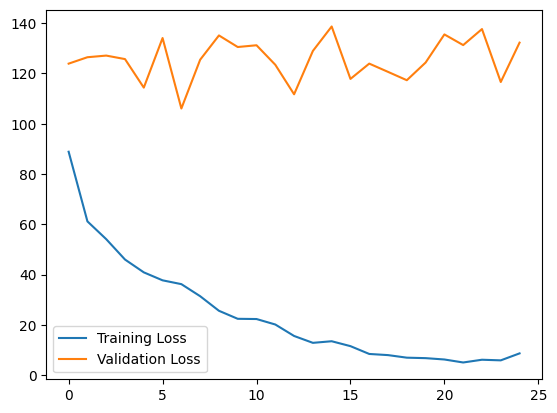

In [70]:
plt.clf()
plt.plot(getattr(trainer, "loss"), label="Training Loss")
plt.plot(getattr(validator, "loss"), label="Validation Loss")
plt.legend()
plt.savefig("MyDrive/ICT303_Results/MLP/MLP_Loss_Plot.jpg")

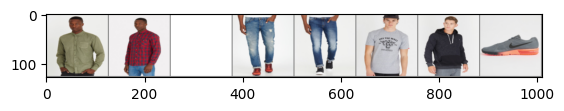

Estimated Labels:  jackets tees  shoes jeans jeans shirts knitwear accessories


In [71]:
testloader = DataLoader().load(dataset="/test", batchSize=10, shuffle=False, workers=2)
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device)

imgShow(torchvision.utils.make_grid(images))
output = model(images).to(device)
estimatedLabels = torch.max(output, 1).indices

print('Estimated Labels: ', ' '.join(f'{classes[estimatedLabels[j]]:5s}' for j in range(images.shape[0])))

In [ ]:
resume = False
if resume:
  epochs = model.load(dir="Mydrive/ICT303_Results/MLP/MLP_Epoch_24.tar")
  trainer.load(dir=f"Mydrive/ICT303_Results/MLP/MLP_Epoch_{epochs}_TrainLoss.tar")
  validator.load(dir=f"Mydrive/ICT303_Results/MLP/MLP_Epoch_{epochs}_ValLoss.tar")